In [1]:
import pandas as pd
import numpy as np
import sys
import yaml
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from mnist import MNIST

sys.path.insert(1, '/home/guilherme-resende/Desktop/mono2/utils')
import qif

In [2]:
RANDOM_SEED = 1
MAX_DEPTHS = [2,4,8,16]
N_ESTIMATORS = [16,32,64,128,256]

#### Load Data

In [3]:
ds_name = "mnist"

In [4]:
datasets = yaml.load(open("datasets.yaml"))
df = pd.read_csv(datasets[ds_name]["path"])

df_train = df.loc[df.set == "train"].drop("set", axis=1).reset_index(drop=True)
df_test = df.loc[df.set == "test"].drop("set", axis=1).reset_index(drop=True)

del df

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


#### Create Input

In [5]:
X_train = df_train.drop("targets", axis=1)
Y_train = df_train.targets

X_test = df_test.drop("targets", axis=1)
Y_test = df_test.targets

#### Training Process

In [6]:
model = XGBClassifier(max_depth=4, n_estimators=128)
model.fit(X_train.values, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=128, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Prediction Process

In [7]:
preds = model.predict(X_test.values)
preds_proba = model.predict_proba(X_test.values)[:, 1:]

#### Select a Given Class to Analyze

In [8]:
digit = 5

In [9]:
df_test = df_test[df_test.targets == digit]

In [10]:
df_test["preds_proba"] = preds_proba[df_test.index][:, digit-1]

In [11]:
df_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,targets,preds_proba
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0.620164
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0.884980
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0.996474


#### Calculate SHAP

In [12]:
X_test = df_test.drop(["targets", "preds_proba"], axis=1)

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.values)

shap_values = np.array(shap_values)[digit]

shap_values = shap_values.mean(axis=0)

#### Visualize SHAP

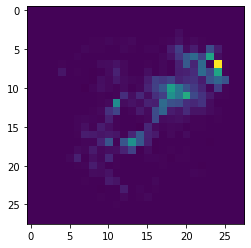

In [23]:
plt.imshow(np.array(shap_values).reshape((28, 28)))
plt.show()

#### Calculate QIF

In [15]:
feature_names = X_test.columns

In [16]:
bayes_leakage = qif.BayesLeakage(df_test)

In [17]:
qif_values = []
for feature in feature_names:
    leakage = bayes_leakage.compute_flows(x=feature, y='preds_proba')
    qif_values.append(leakage[0])

#### Visualize QIF

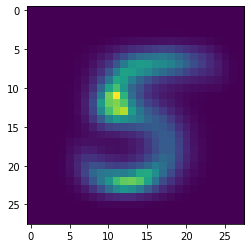

In [18]:
plt.imshow(np.array(qif_values).reshape((28, 28)))

#### Save Coeficients

In [19]:
df = pd.DataFrame([shap_values, qif_values], columns=feature_names)
df["method"] = ["SHAP", "QIF"]

df.to_csv(f"../data/results/{ds_name}_coeficients.csv")